## Textract Sample notebook

This notebook shows how to use Textract API through Boto3 SDK

**** Please make sure trp.py file is in same folder
trp.py has helper classes to parse Textract JSON output ****

In [1]:
import boto3
import io
from io import BytesIO
import trp

TEXTRACT_REGION = 'us-east-1'

### Download sample image file

In [2]:
!wget https://s3.us-east-1.amazonaws.com/textract-public-assets-us-east-1/default_document.png

--2019-10-07 05:59:00--  https://s3.us-east-1.amazonaws.com/textract-public-assets-us-east-1/default_document.png
Resolving s3.us-east-1.amazonaws.com (s3.us-east-1.amazonaws.com)... 52.216.113.125
Connecting to s3.us-east-1.amazonaws.com (s3.us-east-1.amazonaws.com)|52.216.113.125|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15508 (15K) [image/png]
Saving to: ‘default_document.png.2’

default_document.pn 100%[===================>]  15.14K  --.-KB/s    in 0s      

2019-10-07 05:59:01 (197 MB/s) - ‘default_document.png.2’ saved [15508/15508]



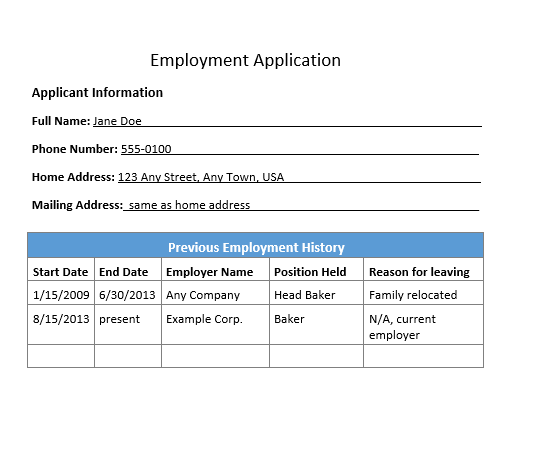

In [3]:
from IPython.display import Image
Image("default_document.png", width='60%')

### Convert document to byte array and send it to Textract

In [4]:
img = open('default_document.png', 'rb')
data = io.BytesIO(bytearray(img.read()))
data_bytes = data.getvalue()

textract = boto3.client('textract', region_name=TEXTRACT_REGION)
response = textract.analyze_document(Document={'Bytes': data_bytes}, FeatureTypes=["TABLES", "FORMS"])

print('RAW Response:')
print(response)

RAW Response:
{'DocumentMetadata': {'Pages': 1}, 'Blocks': [{'BlockType': 'PAGE', 'Geometry': {'BoundingBox': {'Width': 1.0, 'Height': 1.0, 'Left': 0.0, 'Top': 0.0}, 'Polygon': [{'X': 0.0, 'Y': 0.0}, {'X': 1.0, 'Y': 0.0}, {'X': 1.0, 'Y': 1.0}, {'X': 0.0, 'Y': 1.0}]}, 'Id': 'd6ebd619-59bf-4f6b-b258-1887d10fc0b8', 'Relationships': [{'Type': 'CHILD', 'Ids': ['75c4ad5e-290f-4c30-b433-6a2915c64e00', '6f6ddb81-6d9d-4631-94a5-83f21d7b385d', 'c7f04961-3ffb-439e-a5ea-83deb1999d4a', 'e5df8993-96c2-43a4-81e3-92d9dcbc80b8', 'e5cdf423-555d-4034-a0e2-cbc68383d51b', 'd3fa8416-3e98-4aaa-a269-768aa9a0162c', 'c1d3688c-7d41-4cad-873d-e581f6db7dca', 'd748a123-5cb7-417f-a9fc-6850d33de328', '19fbd2ec-b7ba-468e-8a2b-ef0d9cb939cc', '2e83c309-5d29-43e0-b4c1-c7b940e02a88', '79e5b090-8234-4011-b374-ad2435d5e290', '85ce2f13-8063-4257-9aa0-1e91f6065866', 'a2f14d11-1492-4c76-844e-0ea0f1befa79', '33195f27-79cc-400c-b7ea-f01c5ffb0c46', 'e321e012-28e1-4547-979e-781f0739a90d', '2d3f9324-9af8-4db9-8323-909b9e5a7729', '0

### Parsed Response

In [5]:
doc = trp.Document(response)

# Iterate over elements in the document
for page in doc.pages:
    # Print lines and words
    for line in page.lines:
        print("Line: {}--{}".format(line.text, line.confidence))
        for word in line.words:
            print("Word: {}--{}".format(word.text, word.confidence))

    # Print tables
    for table in page.tables:
        for r, row in enumerate(table.rows):
            for c, cell in enumerate(row.cells):
                print("Table[{}][{}] = {}-{}".format(r, c, cell.text, cell.confidence))

    # Print fields
    for field in page.form.fields:
        print("Field: Key: {}, Value: {}".format(field.key.text, field.value.text))

    # Get field by key
    key = "Phone Number:"
    field = page.form.getFieldByKey(key)
    if(field):
        print("Field: Key: {}, Value: {}".format(field.key, field.value))

    # Search fields by key
    key = "address"
    fields = page.form.searchFieldsByKey(key)
    for field in fields:
        print("Field: Key: {}, Value: {}".format(field.key, field.value))

Line: Employment Application--99.93033599853516
Word: Application--99.91561126708984
Word: Employment--99.94505310058594
Line: Applicant Information--99.72792053222656
Word: Applicant--99.97581481933594
Word: Information--99.48002624511719
Line: Full Name: Jane Doe--99.73129272460938
Word: Full--99.5636978149414
Word: Doe--99.93549346923828
Word: Jane--99.86280822753906
Word: Name:--99.56318664550781
Line: Phone Number: 555-0100--99.58738708496094
Word: Phone--99.16001892089844
Word: Number:--99.7388916015625
Word: 555-0100--99.86325073242188
Line: Home Address: 123 Any Street, Any Town, USA--96.48639678955078
Word: 123--99.95832824707031
Word: Any--91.10713958740234
Word: Any--87.71688842773438
Word: USA--99.9232406616211
Word: Home--99.83403015136719
Word: Town,--95.1813735961914
Word: Street,--98.32913208007812
Word: Address:--99.84102630615234
Line: Mailing Address: same as home address--99.6951904296875
Word: as--99.7425537109375
Word: same--99.12576293945312
Word: home--99.715248

### Another way to parse

In [6]:
str = ''
for i in response['Blocks']:
    if i['BlockType'] == 'LINE':
        str += i['Text'] + '\n'
print(str)

Employment Application
Applicant Information
Full Name: Jane Doe
Phone Number: 555-0100
Home Address: 123 Any Street, Any Town, USA
Mailing Address: same as home address
Previous Employment History
Start Date
End Date
Employer Name
Position Held
Reason for leaving
1/15/2009
6/30/2013
Any Company
Head Baker
Family relocated
8/15/2013
present
Example Corp
Baker
N/A, current
employer



In [7]:
str = ''
for i in response['Blocks']:
    if i['BlockType'] == 'WORD':
        str += i['Text'] + '\n'
print(str)

Employment
Application
Applicant
Information
Full
Name:
Jane
Doe
Phone
Number:
555-0100
Home
Address:
123
Any
Street,
Any
Town,
USA
Mailing
Address:
same
as
home
address
Previous
Employment
History
Start
Date
End
Date
Employer
Name
Position
Held
Reason
for
leaving
1/15/2009
6/30/2013
Any
Company
Head
Baker
Family
relocated
8/15/2013
present
Example
Corp
Baker
N/A,
current
employer

